In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3D散布図の描画
from sklearn.model_selection import KFold

In [2]:
df_fuels = pd.read_csv("measurements.csv")
display(df_fuels.head())
df_fuels.info()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      376 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null float64
refill gas       13 non-null object
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


### 欠損値の確認

In [3]:
df_fuels.isnull().any(axis=0)

distance         False
consume          False
speed            False
temp_inside       True
temp_outside     False
specials          True
gas_type         False
AC               False
rain             False
sun              False
refill liters     True
refill gas        True
dtype: bool

### temp_inside, specials, refill liters, rfill gasの4つに欠損値あり

### 欠損値を中央値で埋めてみる
special, refill gasは使わない
gas_typeは"E10"なら0とする

In [4]:
df_fuels["temp_inside"].fillna(df_fuels.temp_inside.mean(), inplace=True)
df_fuels["refill liters"].fillna(df_fuels.temp_inside.mean(), inplace=True)
df_fuels.loc[df_fuels['gas_type'] == "E10", 'gas_type'] = 0
df_fuels.loc[df_fuels['gas_type'] == "SP98", 'gas_type'] = 1

df_fuels2 = df_fuels.drop(['specials', 'refill gas'], axis=1)
display(df_fuels2.head())
df_fuels2.info()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill liters
0,28.0,5.0,26,21.5,12,0,0,0,0,45.000000
1,12.0,4.2,30,21.5,13,0,0,0,0,21.929521
2,11.2,5.5,38,21.5,15,0,0,0,0,21.929521
3,12.9,3.9,36,21.5,14,0,0,0,0,21.929521
4,18.5,4.5,46,21.5,15,0,0,0,0,21.929521


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 10 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      388 non-null float64
temp_outside     388 non-null int64
gas_type         388 non-null int64
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    388 non-null float64
dtypes: float64(4), int64(6)
memory usage: 30.4 KB


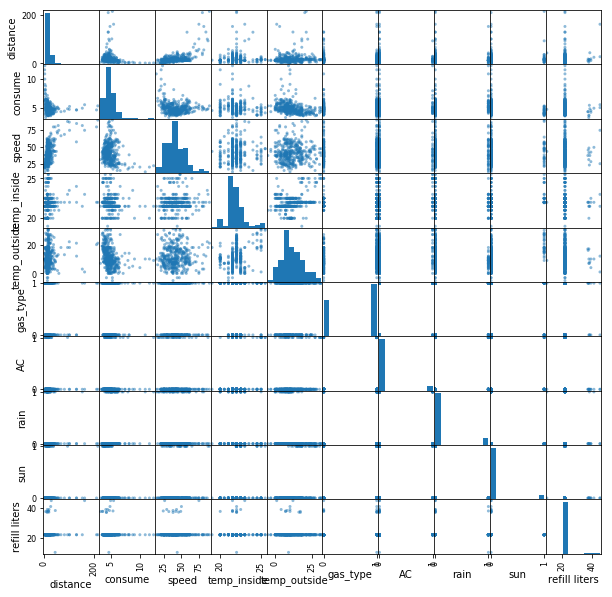

In [5]:
pd.plotting.scatter_matrix(df_fuels2, figsize=(10, 10))
plt.show()

## 交差検証法

In [6]:
y = df_fuels2["consume"].values
X = df_fuels2[["distance", "speed", "temp_inside", "temp_outside", "gas_type", "AC", "rain", "sun", "refill liters"]].values

n_split = 3

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = round(mean_absolute_error(y_test, y_pred_test), 3)
    mse = round(mean_squared_error(y_test, y_pred_test) , 3)
    rmse = round(np.sqrt(mse), 3)
    print("Fold %s"%split_num)
    print('MSE = %s MAE = %s RMSE = %s'%(mse, mae, rmse))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1


Fold 1
MSE = 0.7 MAE = 0.665 RMSE = 0.837

Fold 2
MSE = 1.169 MAE = 0.653 RMSE = 1.081

Fold 3
MSE = 0.821 MAE = 0.577 RMSE = 0.906

